In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


## EDA

In [2]:
# Reading in the data
data = pd.read_csv("insurance[1].csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [4]:
# Checking for NA vals(there are none)
print(data.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


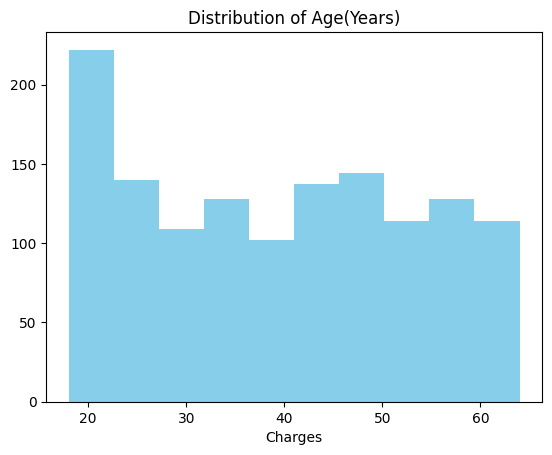

In [5]:
# Making histogram of response variable(heavily skewed)
plt.hist(data['age'], color = 'skyblue', bins = 10)
plt.xlabel('Charges')
plt.title('Distribution of Age(Years)')
plt.show()

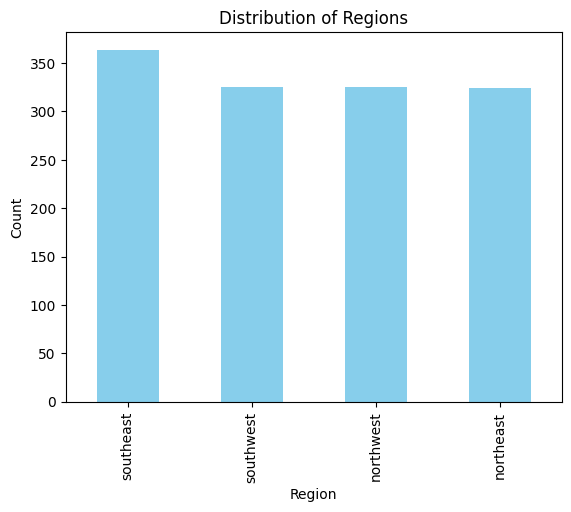

In [6]:
# Bar graph to show distribution of region
data['region'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Distribution of Regions')
plt.show()

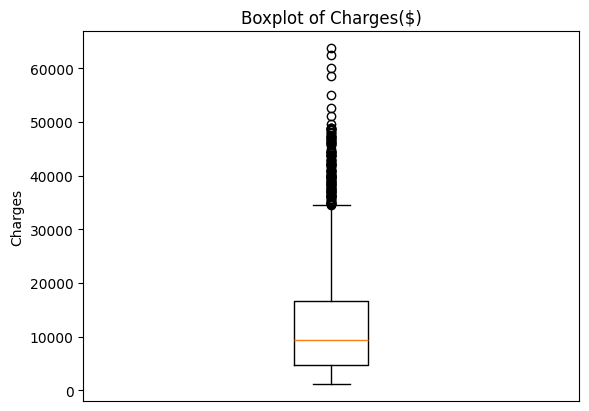

In [7]:
# Boxplot of response(also shows heavy skew)
plt.boxplot(data['charges'])
plt.xticks([])
plt.ylabel('Charges')
plt.title('Boxplot of Charges($)')
plt.show()

In [8]:
# Summary statistic of our response variable
charges_summary = data['charges'].describe().to_frame().reset_index()
charges_summary.columns = ['Statistic', 'Value']
charges_summary['Value'] = charges_summary['Value'].round(2)
charges_summary

,Statistic,Value
0,count,1338.00
1,mean,13270.42
2,std,12110.01
3,min,1121.87
4,25%,4740.29
5,50%,9382.03
6,75%,16639.91
7,max,63770.43


In [9]:
# Encoding smoker, sex, and region
data[["smoker"]] = OrdinalEncoder().fit_transform(data[["smoker"]])
print(data["smoker"].value_counts())

data["sex"] = LabelEncoder().fit_transform(data["sex"])
print(data["sex"].value_counts())

data["region"] = LabelEncoder().fit_transform(data["region"])
print(data["region"].value_counts())

smoker
0.0    1064
1.0     274
Name: count, dtype: int64
sex
1    676
0    662
Name: count, dtype: int64
region
2    364
3    325
1    325
0    324
Name: count, dtype: int64


In [10]:
# Percentiles for response varaible to determine bins
percentiles = np.percentile(data['charges'], [20, 40, 60, 80])
print(percentiles)

[ 3991.57572   7369.05273  11399.85716  20260.626406]


In [11]:
# Manually encoding response variable, creating a new one
data['charge_class'] = data['charges'].apply(lambda x: 0 if x < 3991.5757 else 1 if x < 7369.05 else 2 if x < 11399.85716 else 3 if x < 20260.626406 else 4)

In [12]:
# Train/tune/test split(stratifying by our response variable)
X = data.drop(columns=['charges', 'charge_class'])
y = data['charge_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, random_state=72)

# Creating kfold object for validation
kf = RepeatedKFold(n_splits=10, n_repeats =5, random_state=10)

# Using f1 score(unbalanced dataset) and balanced accuracy
scoring = ['f1_macro','balanced_accuracy']
#Starting with just one parameter of max depth
param = {"max_depth" : [1,2,3,4,5]}

cl= DecisionTreeClassifier(random_state=1000)

#Gridsearch to find best max depth
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_macro')

model = search.fit(X_train, y_train)
best = model.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=5, random_state=1000)


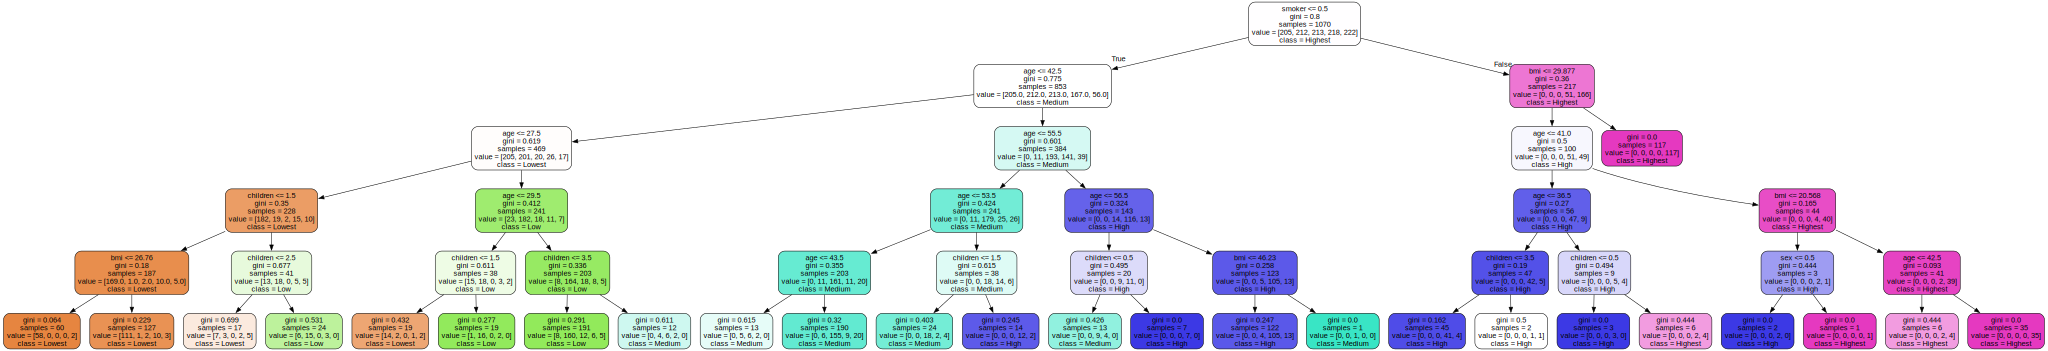

In [13]:
# Visualization of decision tree
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns, # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['Lowest', 'Low', 'Medium', 'High', 'Highest']) # classification labels 
graph_1 = graphviz.Source(dot_data)
graph_1 = graphviz.Source(dot_data)
graph_1
#graph_1.view()

In [14]:
# Variable importance
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
varimp['importance'] = varimp['importance'].round(2)
print(varimp)

          importance
age             0.66
smoker          0.20
children        0.09
bmi             0.05
sex             0.00
region          0.00


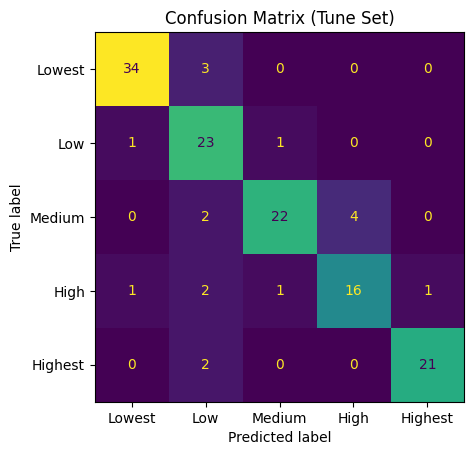

In [15]:
# Confusion matrix of our tune data
ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['Lowest','Low','Medium','High','Highest'], colorbar=False)
plt.title('Confusion Matrix (Tune Set)')
plt.show()


In [16]:
# Predictions, classifcation report of important scores

y_pred_tune = best.predict(X_tune)
y_pred_test = best.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     1.0000    0.8846    0.9388        26
           1     0.8000    0.9333    0.8615        30
           2     0.8077    0.7778    0.7925        27
           3     0.8333    0.8929    0.8621        28
           4     0.9500    0.8261    0.8837        23

    accuracy                         0.8657       134
   macro avg     0.8782    0.8629    0.8677       134
weighted avg     0.8731    0.8657    0.8665       134



Recreating tree based on gridsearch of many parameters to see if this improves performance

In [17]:
# Train/tune/test split(stratify by response)
X = data.drop(columns=['charges', 'charge_class'])
y = data['charge_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, random_state=72)

# Creating kfold object for validation
kf = RepeatedKFold(n_splits=10, n_repeats =5, random_state=10)

scoring = ['f1_macro','balanced_accuracy']
param_grid = {'max_depth': range(3, 8),
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 7],
    'criterion': ['gini', 'entropy']}
cl= DecisionTreeClassifier(random_state=1000)

# Gridsearch based on our parameters
search = GridSearchCV(cl, param_grid, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_macro')

model = search.fit(X_train, y_train)
best = model.best_estimator_
print(best)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       min_samples_split=5, random_state=1000)


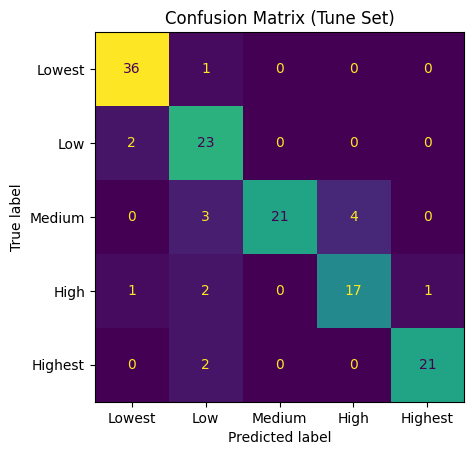

In [18]:
# New confusion matrix display
ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['Lowest','Low','Medium','High','Highest'], colorbar=False)
plt.title('Confusion Matrix (Tune Set)')
plt.show()

In [19]:
y_pred_tune = best.predict(X_tune)
y_pred_test = best.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=4))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9259    0.9615    0.9434        26
           1     0.8966    0.8667    0.8814        30
           2     0.8077    0.7778    0.7925        27
           3     0.7879    0.9286    0.8525        28
           4     1.0000    0.8261    0.9048        23

    accuracy                         0.8731       134
   macro avg     0.8836    0.8721    0.8749       134
weighted avg     0.8794    0.8731    0.8735       134



In [20]:
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
varimp['importance'] = varimp['importance'].round(2)
print(varimp)

          importance
age             0.55
smoker          0.27
children        0.10
bmi             0.06
sex             0.01
region          0.00


In [21]:
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns, # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['Lowest', 'Low', 'Medium', 'High', 'Highest']) # classification labels 
graph_2 = graphviz.Source(dot_data)
graph_2 = graphviz.Source(dot_data)
graph_2
#graph_2.view()

'Source.gv.pdf'